# Fracture extrusion

This tutorial shows how to create a 3D fracture network from a 2D outcrop. The idea is to provide a more complete documentation, an example, and highlight assumptions and simplifications in the module.

## What can this module do?
1. Create a 3D fracture network that is consistent with a flat 2D outcrop, in the sense that if the 3D network is cut at the outcrop height, the 2D network should be reproduced.
2. Produce circular fracture planes, potentially cut, with a prescribed or random dip angle.
3. Preserve Y/T-intersections, in the sense that if one fracture ends in another in the outcrop, this relation will be kept in the extruded network. However, fractures that meet outside the outcrop plane will not be cut in this way.


## What is missing 
1. A geological foundation for the way the extrusion is carried out. What is here so far is an attempt to apply common sense, but nothing more.
2. Population of fractures that do not intersect with the outcrop plane. These will have to be assigned e.g. by stochatsic rules, but this is beyond the scope of PorePy.
3. Extrusion to other than circular shapes.
4. ...

### Will any of the missing pieces be implemented shortly?
There are no concrete plans for this.

## What is the intended use for the model?
Simulations in quasi-realistic (somewhat generously interpreted) geometries. Typically, a verification that developed numerical schemes etc. can handle first test towards real geometries.


# How to use

First, import statements

In [2]:
import numpy as np
import porepy as pp

The starting point for the extrusion is an outcrop, described by endpoints and connection between points.

Note that fractures should *not* be split into branches before applying extrusion. The reasons are 
1. The extrusion is carried out by drawing circles through the endpoints of the fractures (the outcrop trace is a chord). Lines through branches will create all sort of problems.
2. Abutting relations (T-intersections) are identified by comparing original and split (by the extrusion algorithm) traces.

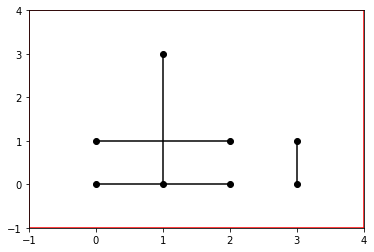

In [3]:
# Define points and connections
pt = np.array([[0, 0], [2, 0], [1, 0], [1, 3], [0, 1], [2, 1], [3, 0], [3, 1]]).T
edges = np.array([[0, 1], [2, 3], [4, 5], [6, 7]]).T

# Temporary min-max coordinates, only valid for 2d domain
domain = {'xmin': -1, 'xmax': 4, 'ymin':-1, 'ymax': 4}
pp.plot_fractures(domain, pt, edges)

The edges are defined so that fractures 0 and 1 define a Y-intersection, 1 and 2 an X-intersection, while no 3 is isolated.

Next, we extrude the fractures, collect them in a FractureNetwork, and export to Paraview.

In [11]:
fractures = pp.extrusion.fractures_from_outcrop(pt, edges)
network = pp.FractureNetwork(fractures)
network.to_vtk('extrusion_1.vtu')

The resulting network looks as follows

<img src="fig/extrusion_1.png" alt="Drawing" style="width: 400px;"/>


Observations:
1. The Y-intersection between 0 and 1 is preserved in the 3d version of the network, while fractures 1 and 2 cuts through each other.
2. Although fracture 3 was isolated in the outcrop, it cuts fracture 0 somewhere underneath.

Also note that, as the height of the fracture center was decided randomly by the extrusion, the network will look different from one realization to the next.


# Assumptions
1. All extruded fractures will be circles, for lack of more information.
2. The fractures are assumed to be cut at an arbitrary height relative to their center. In the extrusion, the z-coordinate of the center, thus the radius of the fracturce, is drawn as random numbers. The behavior can be overruled by the parameter 'extrusion_angle', which should be between 0 and $\pi$. Note that the limiting cases define infinite fractures, while $\pi/2$ will give a point contact in the outcrop plane, none of which are physical.
3. Depending on the fracture radius, the above procedure may yield a T-intersection where the terminated fracture extends beyond the constraining fracture. To avoid this, the size of the constraining fracture will be increased, that is, the z-coordinate of the center is modified. This behavior can be overruled by setting the optional parameter 'ensure_realistic_cuts' to False.


# T-intersections and tolerances
Whether two lines are found to intersect in a T, X, or not at all depends on the tolerance used in geometric calculations. While this applies to most geometry computations in PorePy, there is a particular issue that may arise when working with outcrop data: When fractures are collected into a database, points in T-intersections are routinely snapped to the abutting fracture. In the decision to snap, a tolerance is applied, at least implicitly.

When the extrusion model is invoked, it will identify T-intersections based on a user defined tolerance that may not be the same as in the snapping process. Moreover, it is not clear that the two tolerances mean the same. We have experienced some issues with what from the user side was considered T-intersections was treated as X-intersections by the extrusion module because of this.

To deal with this:
1. Inspect the extruded fracture network, and see if you find the expected T-intersections.
2. If necessary, redo the snapping with a tolerance sufficient to make extrusion behave well. The function snap_points_to_segments in the comp_geom model can be used for this.

It should also be quite easy to rewrite the extrusion model to accept a pre-computed topology, however, this has not been prioritized.

# More advanced features
In addition to the basic features described above, the extrusion module has some more advanced features that goes further towards creating more realistic networks. These are however also less tested. It is not clear whether the approach will ever create something resembling geological realism. Anyhow, the features are:
1. Assign inclines to angles, so that they are not all vertical.
2. Use family-based parameters, so that fractures that are grouped together (say, were created under the same geological regime) are assigned similar parameters, but different from other families.